**Implementing a deep CNN using pytorch:**

**Loading and preprocessing the data:**

In [4]:
import torch

In [8]:
import torch.nn as nn

In [1]:
import torchvision
from torchvision import transforms

image_path = '../../data/mnist'

transform = transforms.Compose([
    transforms.ToTensor()
])

mnist_dataset = torchvision.datasets.MNIST(root=image_path, train=True, transform=transform, download=False)

In [2]:
from torch.utils.data import Dataset, DataLoader, Subset

In [5]:
mnist_valid_dataset = Subset(mnist_dataset, torch.arange(10000))
mnist_train_dataset = Subset(mnist_dataset, torch.arange(10000, len(mnist_dataset)))

In [6]:
mnist_test_dataset = torchvision.datasets.MNIST(
    root=image_path, train=False, transform=transform, download=False
)

Next, we construct the data loader with batches of 64 images for the training and validation sets:

In [7]:
batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_valid_dataset, batch_size, shuffle=False)

The features we read are of values in the range [0, 1] - no additional scaling required henceforth. also, we already converted the images to tensors. the labels are also integers from 0 to 9, representing 10 digits. 

**Configuring CNN layers in Pytorch:**
- Constructing a layer with the conv2d class requires us to specify the number of output channels (output feature maps), and the kernel size.
- In addition - there's optional parameters we use for configuring the cnn - these include the strides, and padding. 
- Also worth mentioning that when we read an image, the default dimensions for the channels is the first dimension of the tensor, this is called the NCHW format, where the N stands for the number of images within the batch, C stands for the channels, H and W for the height and width respectively.
- Note that conv2d assumes that the inputs are in NCHW format by default (tensorflow uses the NHWC format). 
- Next after that we have maxpooling
- then dropout's in there as well

**Constructing a CNN in pytorch:**

In [10]:
model = nn.Sequential()

model.add_module(
    'conv1',
    nn.Conv2d(
        in_channels=1, out_channels=32,
        kernel_size=5, padding='same'
    )
)
model.add_module('relu1',nn.ReLU())
model.add_module('pool1',nn.MaxPool2d(kernel_size=2))
model.add_module(
    'conv2',
    nn.Conv2d(
        in_channels=32, out_channels=64,
        kernel_size=5, padding='same'
    )
)
model.add_module('relu2',nn.ReLU())
model.add_module('pool2',nn.MaxPool2d(kernel_size=2))

while we can calculate the size of the feature maps at this stage manually, pytorch provides a convenient method for us to compute this

In [12]:
x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 64, 7, 7])

By providing the input shape as a tuple (4, 1, 28, 28) (4 images within the batch, 1 channel, and image size 28x28) - we calculated the output to have a shape of (4, 64, 7, 7). indivating feature maps with 64 channels and a spatial size of 7x7. Next layer - is a FC kayer for implementing a classifier on top of our convolutional and pooling layers. The input to this layer must have rank 2, i.e. shape of [batch_size x input_units], thus we need to flatten the output of the previous layer to meet this requirement for the fc layer.

In [13]:
model.add_module('flatten', nn.Flatten())
x = torch.ones((4, 1, 28, 28))
model(x).shape

torch.Size([4, 3136])

as the output now indicates the input dimensions for the fully connected layer correctly set up - next we add 2 fully connected layers with a dropout layer in between:

In [14]:
model.add_module('fc1', nn.Linear(3136, 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout', nn.Dropout(p=0.5))
model.add_module('fc2', nn.Linear(1024, 10))

no need to manually implement softmax as thats implemented inside pytorch's crossentropyloss function.

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
len(valid_dl)

157

In [20]:
len(valid_dl.dataset)

10000

Now, we can train the model by defining the following function:

In [21]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0]*num_epochs
    accuracy_hist_train = [0]*num_epochs
    loss_hist_valid = [0]*num_epochs
    accuracy_hist_valid = [0]*num_epochs

    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (
                torch.argmax(pred, dim=1) == y_batch
            ).float()
            accuracy_hist_train[epoch] += is_correct.sum()
        
        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()

        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (
                    torch.argmax(pred, dim=1) == y_batch
                ).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f"Epoch {epoch+1} | accuracy: {accuracy_hist_train[epoch]:.4f} | val_accuracy: {accuracy_hist_valid[epoch]:.4f}")
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid



In [22]:
torch.manual_seed(1)
num_epochs = 20
hist = train(model, num_epochs, train_dl, valid_dl)

Epoch 1 | accuracy: 0.9489 | val_accuracy: 0.9779
Epoch 2 | accuracy: 0.9844 | val_accuracy: 0.9866
Epoch 3 | accuracy: 0.9883 | val_accuracy: 0.9882
Epoch 4 | accuracy: 0.9917 | val_accuracy: 0.9896
Epoch 5 | accuracy: 0.9925 | val_accuracy: 0.9863
Epoch 6 | accuracy: 0.9949 | val_accuracy: 0.9892
Epoch 7 | accuracy: 0.9945 | val_accuracy: 0.9892
Epoch 8 | accuracy: 0.9953 | val_accuracy: 0.9905
Epoch 9 | accuracy: 0.9957 | val_accuracy: 0.9909
Epoch 10 | accuracy: 0.9975 | val_accuracy: 0.9882
Epoch 11 | accuracy: 0.9968 | val_accuracy: 0.9894
Epoch 12 | accuracy: 0.9973 | val_accuracy: 0.9919
Epoch 13 | accuracy: 0.9975 | val_accuracy: 0.9911
Epoch 14 | accuracy: 0.9978 | val_accuracy: 0.9895
Epoch 15 | accuracy: 0.9975 | val_accuracy: 0.9911
Epoch 16 | accuracy: 0.9978 | val_accuracy: 0.9908
Epoch 17 | accuracy: 0.9982 | val_accuracy: 0.9913
Epoch 18 | accuracy: 0.9985 | val_accuracy: 0.9898
Epoch 19 | accuracy: 0.9978 | val_accuracy: 0.9897
Epoch 20 | accuracy: 0.9985 | val_accura

we can now visualise the learning curves:

In [25]:
import matplotlib.pyplot as plt
import numpy as np

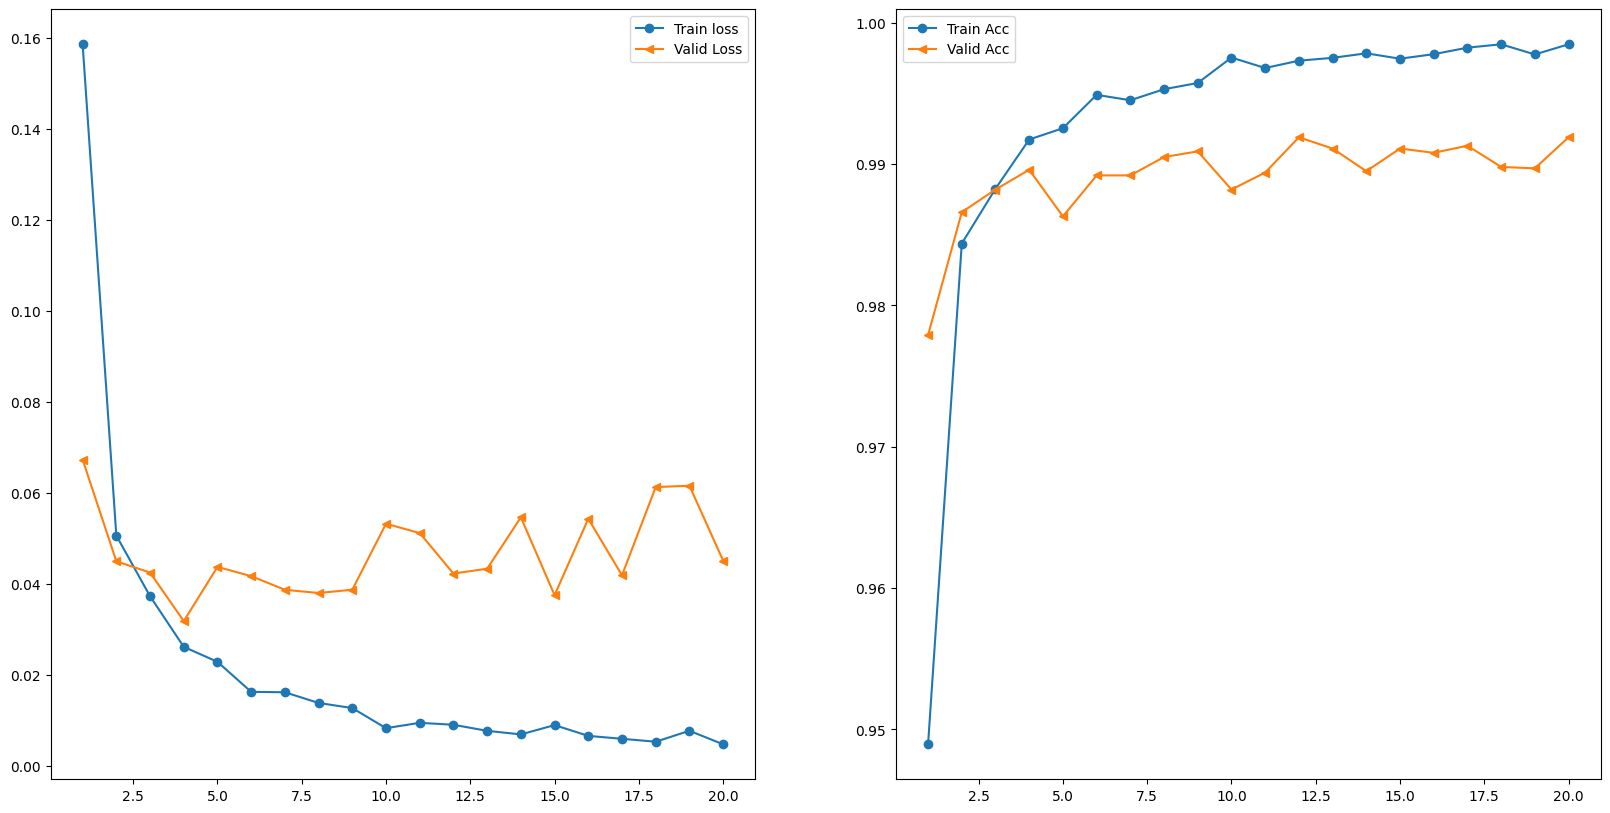

In [26]:
x_arr = np.arange(len(hist[0])) + 1

fig, ax = plt.subplots(1,2,figsize=(20,10))

ax[0].plot(x_arr, hist[0],'-o',label='Train loss')
ax[0].plot(x_arr, hist[1],'-<',label='Valid Loss')
ax[0].legend()

ax[1].plot(x_arr, hist[2],'-o',label='Train Acc')
ax[1].plot(x_arr, hist[3],'-<',label='Valid Acc')

ax[1].legend()

Now, we evaluate the model on the test dataset:

In [28]:
mnist_test_dataset.data.shape

torch.Size([10000, 28, 28])

In [29]:
model.eval()
pred = model(mnist_test_dataset.data.unsqueeze(1)/255)

is_correct = (
    torch.argmax(pred, dim=1) == mnist_test_dataset.targets
).float()

print(f'Test accuracy: {is_correct.mean():.4f}')

Test accuracy: 0.9934


Finally, we can get the prediction results in the form of class-membership probabilities and convert them to predicted labels using the torch.argmax function to find the element with the maximum probability. 

In [34]:
mnist_test_dataset[0][0][0,:,:].shape

torch.Size([28, 28])

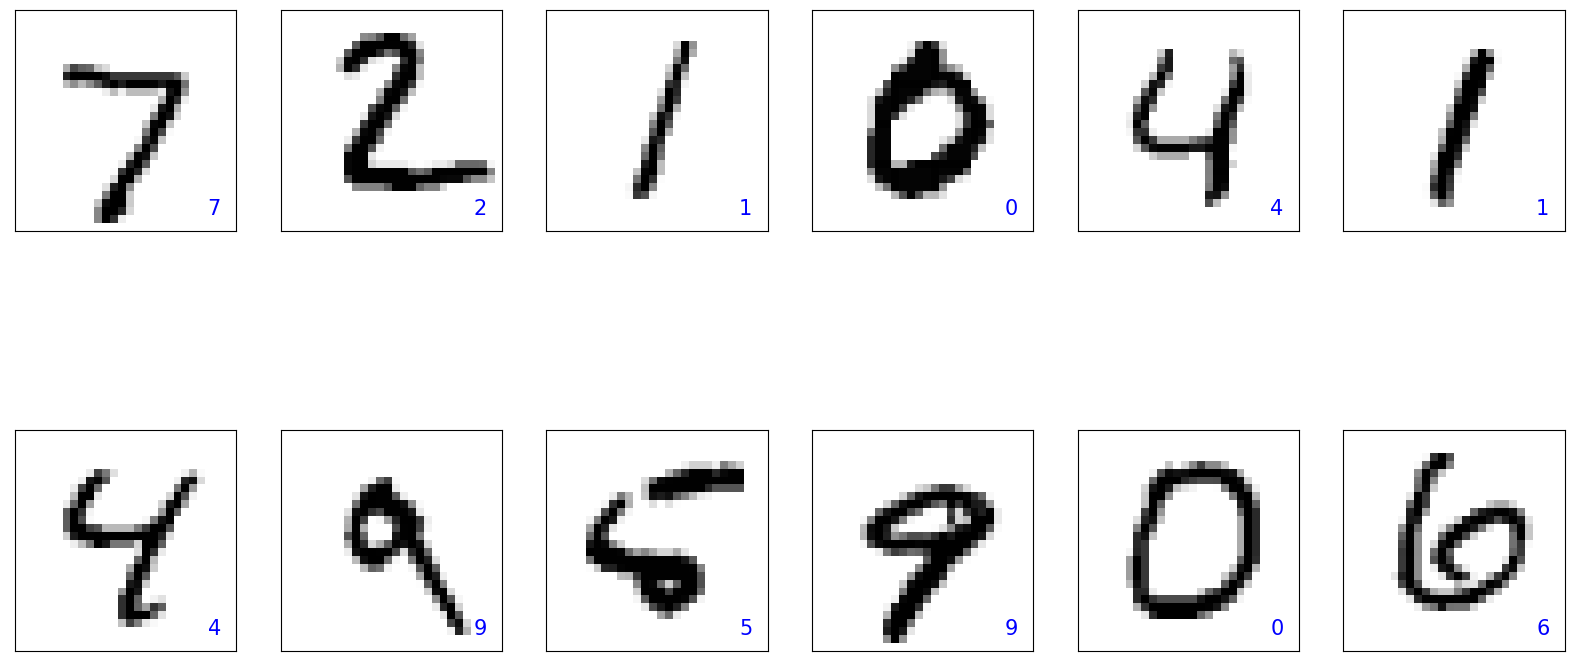

In [42]:
fig, ax = plt.subplots(2,6,figsize=(20,10))

counter = 0
for i in range(2):
    for j in range(6):
        ax[i,j].set_xticks([]);
        ax[i,j].set_yticks([]);
        img = mnist_test_dataset[counter][0][0,:,:]
        pred = model(img.unsqueeze(0).unsqueeze(1))
        y_pred = torch.argmax(pred)
        ax[i,j].imshow(img, cmap='gray_r')
        ax[i,j].text(0.9, 0.1, y_pred.item(),size=15,color='blue',horizontalalignment='center',verticalalignment='center',transform=ax[i,j].transAxes)
        counter+=1
plt.show()


Visualise some of the misclassified digits:

In [43]:
mnist_test_dataset.data.shape

torch.Size([10000, 28, 28])

In [45]:
mnist_test_dataset.targets.shape

torch.Size([10000])

In [47]:
# switch to eval mode
model.eval()
# make predictions
preds = model(mnist_test_dataset.data.unsqueeze(1)/255)

In [52]:
preds_normalized = torch.argmax(preds, dim=1).int()

In [55]:
req_indices = np.argwhere(preds_normalized.clone().numpy() != mnist_test_dataset.targets.clone().numpy())

In [57]:
req_indices = req_indices.reshape(66,)

In [61]:
preds[req_indices,:].shape

torch.Size([66, 10])

In [65]:
mnist_test_dataset.targets.shape

torch.Size([10000])

In [66]:
misclassified_data = mnist_test_dataset.data[req_indices,:,:]
misclassified_model_labels = preds_normalized[req_indices]
misclassified_true_labels = mnist_test_dataset.targets[req_indices]

In [70]:
misclassified_data[0].shape

torch.Size([28, 28])

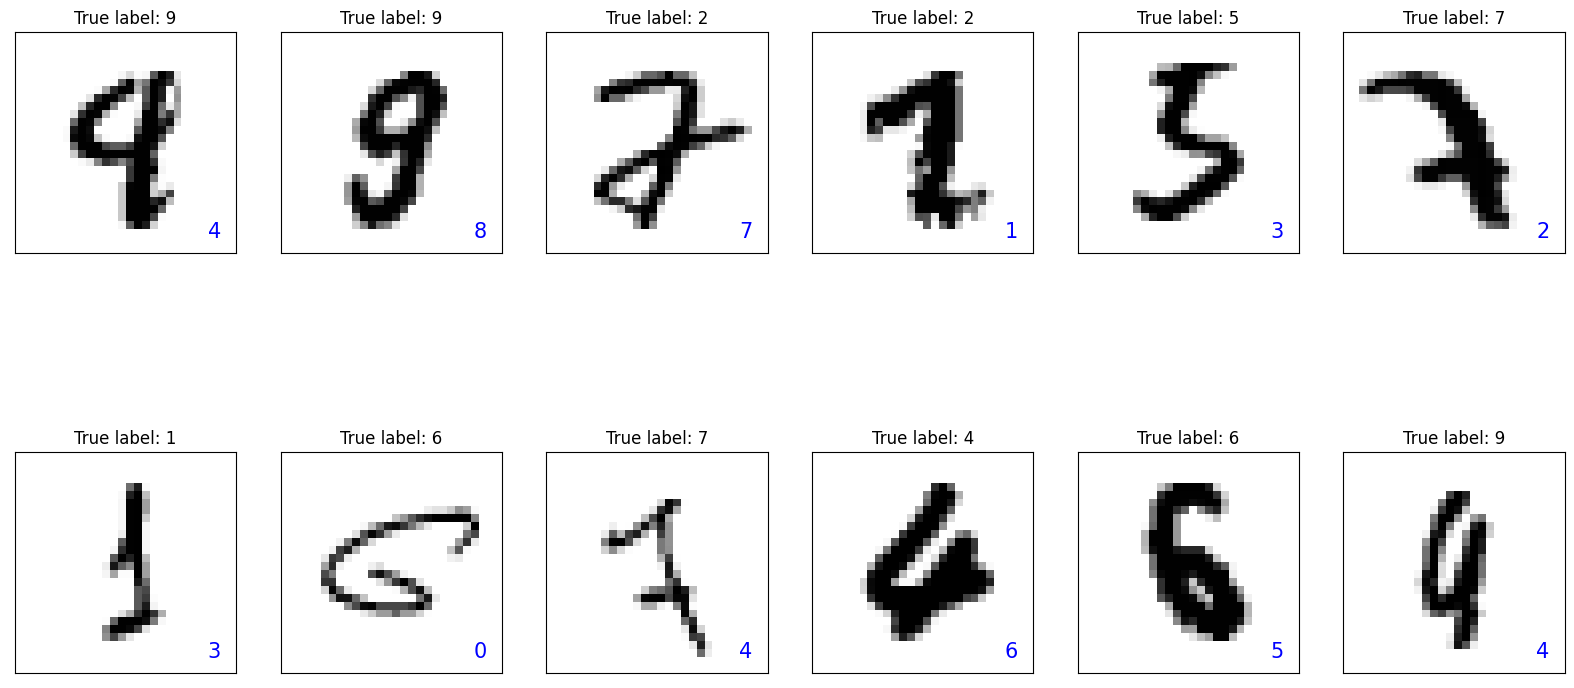

In [73]:
fig, ax = plt.subplots(2,6,figsize=(20,10))

counter = 0
for i in range(2):
    for j in range(6):
        ax[i,j].set_xticks([]);
        ax[i,j].set_yticks([]);
        img = misclassified_data[counter]
        y_pred = misclassified_model_labels[counter]
        ax[i,j].imshow(img, cmap='gray_r')
        ax[i,j].text(0.9, 0.1, y_pred.item(),size=15,color='blue',horizontalalignment='center',verticalalignment='center',transform=ax[i,j].transAxes)
        ax[i,j].set_title(f"True label: {misclassified_true_labels[counter]}")
        counter+=1
plt.show()

In [74]:
from PIL import Image

In [ ]:
with Image.open("../../data/cat_dog_images/cat-02.jpg").convert("RGB") as im:
    print

In [77]:
img = Image.open("../../data/cat_dog_images/cat-02.jpg").convert("RGB")

In [79]:
from torchvision.transforms import ToTensor

In [80]:
z = ToTensor()
y = z(img)

In [81]:
y.shape

torch.Size([3, 900, 1200])